In [1]:
# Add parent dir to path for utils access
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))

# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import rasterio 
import rioxarray as rio
import cf_xarray
import earthaccess
import utilities.useful_functions as utils
from rasterio.enums import Resampling

# Set up known scenes and time to search through
bbox = {"mb":(-102, 53.5, -92, 59), "la":(-120, 33, -116, 35),}
tspan = ("2024-12-07", "2024-12-18")

In [2]:
# Set credentials
auth = earthaccess.login(persist=True)

In [4]:
# Grabbing LA pre-fire granules
# Cloud cover is whole granule, so must look at worldview to choose
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan,
    bounding_box=bbox["la"],
    cloud_cover=(0, 75)
)
results[-1]

Collection: {'ShortName': 'PACE_OCI_L2_SFREFL', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 38.30287, 'Longitude': -103.18227}, {'Latitude': 32.77948, 'Longitude': -132.10988}, {'Latitude': 15.29496, 'Longitude': -125.72665}, {'Latitude': 20.41511, 'Longitude': -101.07798}, {'Latitude': 38.30287, 'Longitude': -103.18227}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-12-18T20:27:30Z', 'BeginningDateTime': '2024-12-18T20:22:31Z'}}
Size(MB): 743.6411561965942
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241218T202231.L2.SFREFL.V3_0.nc']

In [5]:
# Grab two specific prefire granules 
# (had to worldview it for clear sky over LA)
results = [results[0], results[-1]]
paths = earthaccess.open(results)
paths

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20241207T203537.L2.SFREFL.V3_0.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20241218T202231.L2.SFREFL.V3_0.nc>]

In [6]:
# Open, subset, and mask prefire files (~2 mins on cryocloud)
import time
start = time.time()
prefire_1, prefire_2 = utils.open_nc(paths[0]), utils.open_nc(paths[1])

# Subset to necessary bands
prefire_1 = prefire_1.sel({"wavelength_3d":[1038, 2131]}, method="nearest")
prefire_2 = prefire_2.sel({"wavelength_3d":[1038, 2131]}, method="nearest")

# Subset and Mask 
prefire_1, prefire_2 = utils.subset(prefire_1, bbox["la"]), utils.subset(prefire_2, bbox["la"])
prefire_1, prefire_2 = utils.mask_ds(prefire_1), utils.mask_ds(prefire_2)
end=time.time()
print(f"Code took {(end - start) / 60} mins to run")

Code took 1.3922041217486063 mins to run


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


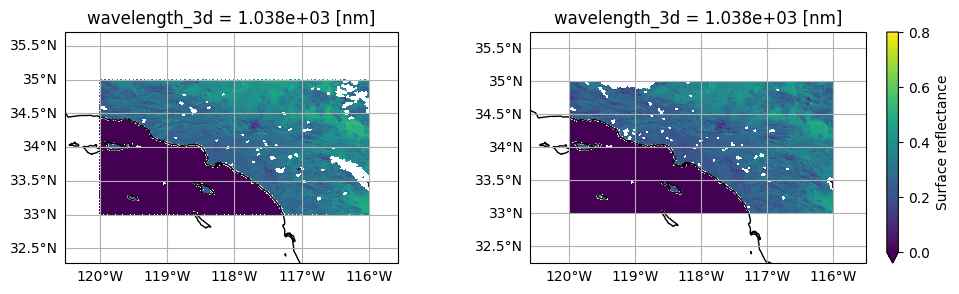

In [7]:
# Plot to make sure everything worked
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax[0].coastlines()
ax[1].coastlines()
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
prefire_1.rhos[:,:,0].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[0], add_colorbar=False)
prefire_2.rhos[:,:,0].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax[1])
plt.show()

In [8]:
# Project first prefire granule to get grid
dst = utils.reproject_3d(prefire_1["rhos"])
crs = dst.rio.crs
shape = dst.rio.shape
transform = dst.rio.transform()

# Project 2nd prefire
pf2_dst = utils.grid_match_3d(prefire_2["rhos"], crs=crs,
                              dst_shape=shape,
                              transform=transform)

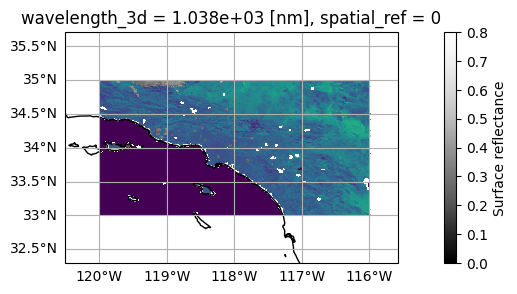

In [10]:
# Overlay to make sure datasets match
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,3))
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, cmap="Greys_r")
pf2_dst[0,:,:].plot(x="longitude", y="latitude", vmin=0, vmax=0.8, ax=ax, add_colorbar=False)
plt.show()

In [11]:
pre_all = xr.combine_nested([dst, pf2_dst],concat_dim="time")
pre_all

# avg each wl prefire then repeat all steps for post

<xarray.DataArray 'rhos' (time: 2, wavelength_3d: 2, latitude: 272,
                          longitude: 393)> Size: 2MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]],
      shape=(2, 2, 272, 393), dtype=float32)
Coordinates:
  * longitude      (longitude) float64 3kB -120.5 -120.5 ... -115.6 -115.6
  * latitude       (latitude) float64 2kB 35.71 35.69 35.68 ... 32.32 32.31 32.3
  * wavelength_3d  (wavelength_3d) float64 16B 1.038e+03 2.131e+03
    spatial_ref    int64 8B 0
Dimensions without coordinates: time

<xarray.DataArray 'rhos' (wavelength_3d: 122, latitude: 455, longitude: 493)> Size: 109MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.0269919 , 0.0269919 , 0.02753801, ..., 0.12368221,
         0.11307739, 0.10214047],
        [0.02633941, 0.02515255, 0.02612089, ..., 0.12495179,
         0.10437866, 0.09900002],
        [0.02554115, 0.02621901, 0.0259231 , ..., 0.12344661,
         0.09621884, 0.09406163]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.00147568, 0.00147568, 0.00146046, ..., 0.41849837,
         0.35251665, 0.30816737],
        [0.00148441, 0.00195404, 0.00170654, ..., 0.40825003,
         0.32444847, 0.2871591 ],
        [0.00182072, 0.00161232, 0.00172432, ..., 0.4016716 ,
         0.30963123, 0.276267  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00157885, 0.00157885, 0.00160575, ..., 0.38772678,
         0.32915816, 0.28481936],
        [0.00155512, 0.00191514, 0.00176956, ..., 0.38361987,
         0.30223528, 0.26737672],
        [0.00160875, 0.00154076, 0.00151572, ..., 0.37723428,
         0.29185355, 0.25787932]]], shape=(122, 455, 493), dtype=float32)
Coordinates:
  * longitude    (longitude) float64 4kB -121.0 -121.0 -121.0 ... -115.2 -115.2
  * latitude     (latitude) float64 4kB 36.68 36.67 36.66 ... 31.32 31.31 31.3
    spatial_ref  int64 8B 0
Dimensions without coordinates: wavelength_3d
Attributes:
    long_name:  Surface reflectance
    valid_min:  -0.05
    valid_max:  1.0

<xarray.DataArray 'rhos' (wavelength_3d: 122, latitude: 442, longitude: 528)> Size: 114MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude      (longitude) float64 4kB -121.0 -121.0 ... -115.0 -115.0
  * latitude       (latitude) float64 4kB 36.28 36.27 36.26 ... 31.28 31.27
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Attributes:
    long_name:   Surface reflectance
    valid_min:   -0.05
    valid_max:   1.0
    _FillValue:  nan